# Rover Response Optimization

This notebook shows how variables in an fmdtools model can be optimized for resilience.

In [4]:
from fmdtools.sim.approach import SampleApproach
import fmdtools.analyze as an
import fmdtools.sim.propagate as prop
import fmdtools.sim.search as search
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

Model is in defined rover_model.py

In [5]:
from rover_model import Rover, gen_params, plot_map, plot_trajectories

## Optimization

Here we define the optimization problem for the rover.

We use a parallel pool, staged execution, and minimal tracking options to lower computational cost as much as possible.

In [6]:
mdl = Rover()
mdl.modelparams['use_end_condition']=False
track={'functions':{"Environment":"in_bound"},'flows':{"Ground":"all"}}
rover_prob = search.ProblemInterface("rover_problem", mdl, pool=mp.Pool(5), staged=True, track=track)

In [7]:
mdl.params

{'linetype': 'turn',
 'radius': 20,
 'start': 20,
 'initangle': 0.0,
 'end': [40, 40],
 'ub_f': 10,
 'lb_f': -1,
 'ub_t': 10,
 'lb_t': -1,
 'ub_d': 2,
 'lb_d': -2,
 'cor_f': 1,
 'cor_d': 1,
 'cor_t': 1,
 'degradation': {'friction': 0.0, 'drift': 0.0}}

Here we will be optimizing over faults in the drive system at 3 points during the drive simulation interval:

In [8]:
app_drive = SampleApproach(mdl, faults='Drive', phases={'global':[0,39]}, defaultsamp={'samp':'evenspacing','numpts':3})
rover_prob.add_simulation("drive_faults", "multi", app_drive.scenlist)

The variables are the correction factors int the fault management: 

In [9]:
rover_prob.add_variables("drive_faults", ("cor_f", (-10,100)), ("cor_d", (-100, 100)), ("cor_t", (-10,100)), vartype="param")

We can define multiple objectives, below we will use the end distance from find_classification. 

In [10]:
rover_prob.add_objectives("drive_faults", end_dist="end_dist", tot_deviation="tot_deviation")

Here we do some basic timing:

In [11]:
rover_prob.end_dist([0.5,0.5,0.5])
a=time.time()
rover_prob.end_dist([0.6,0.5,0.5])
t=time.time()-a

In [12]:
t

1.0776140689849854

Alternatively, we can use:

In [13]:
rover_prob.time_sims([0.7,0.5,0.5])

Simulation Times:
drive_faults: 1.0858502388000488 s
set_const: 0.0 s
total: 1.0858502388000488


{'drive_faults': 1.0858502388000488, 'set_const': 0.0}

In [14]:
rover_prob

Problem rover_problem                                                   current value
 Variables
 -param cor_f at t=0: (-10, 100)                                               0.7000
 -param cor_d at t=0: (-100, 100)                                              0.5000
 -param cor_t at t=0: (-10, 100)                                               0.5000
 Objectives
 -end_dist: +sum(drive_faults endclass end_dist at t=end)                   3939.6729
 -tot_deviation: +sum(drive_faults endclass tot_deviation at t=end)              0.0000
 Constraints
 -
 Simulations
 -drive_faults: multi scen: 

### Rover Optimization: 

In [15]:
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
import numpy as np

In [16]:
pymoo_prob = rover_prob.to_pymoo_problem(objectives="end_dist")

In [17]:
arg={}
pymoo_prob._evaluate([1,1,2],arg)

In [18]:
arg

{'F': array([[4127.53580878]])}

In [19]:
algorithm=PatternSearch(x0=np.array([0,0,0])) 

In [31]:
res = minimize(pymoo_prob, algorithm, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        1 |  4.179790E+03 |  4.179790E+03
     2 |        7 |  4.164173E+03 |  4.148555E+03
     3 |       13 |  4.142964E+03 |  4.137373E+03
     4 |       20 |  4.135107E+03 |  4.132841E+03
     5 |       27 |  4.132841E+03 |  4.132841E+03
     6 |       33 |  4.083220E+03 |  4.033600E+03
     7 |       39 |  4.260198E+03 |  4.033600E+03
     8 |       45 |  4.033600E+03 |  4.033600E+03
     9 |       50 |  3.973503E+03 |  3.913407E+03
    10 |       57 |  3.913407E+03 |  3.913407E+03
    11 |       62 |  3.879254E+03 |  3.845101E+03
    12 |       69 |  3.845411E+03 |  3.845101E+03
    13 |       74 |  3.844903E+03 |  3.844706E+03
    14 |       81 |  3.844706E+03 |  3.844706E+03
    15 |       86 |  3.820852E+03 |  3.796998E+03
    16 |       92 |  3.794652E+03 |  3.792305E+03
    17 |       98 |  3.791594E+03 |  3.790882E+03
    18 |      104 |  3.791953E+03 |  3.790882E+03
    19 |      110 |  3.790882E+03 |  3.790882E+03


In [32]:
res.X

array([   0.65790489, -100.        ,   -1.45828247])

### Results visualization

Here we look at the optimized results and compare with the starting results:

In [34]:
rover_prob.end_dist([   0.65790489, -100.        ,   -1.45828247])

3786.9304103064123

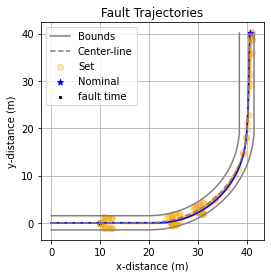

In [35]:
fig = plot_trajectories(rover_prob._sims['drive_faults']['mdlhists'], app= app_drive)

(<Figure size 432x864 with 12 Axes>,
 array([<AxesSubplot:title={'center':'Ground: x'}>,
        <AxesSubplot:title={'center':'Ground: y'}>,
        <AxesSubplot:title={'center':'Ground: liney'}>,
        <AxesSubplot:title={'center':'Ground: linex'}>,
        <AxesSubplot:title={'center':'Ground: lbx'}>,
        <AxesSubplot:title={'center':'Ground: lby'}>,
        <AxesSubplot:title={'center':'Ground: ubx'}>,
        <AxesSubplot:title={'center':'Ground: uby'}>,
        <AxesSubplot:title={'center':'Ground: vel'}>,
        <AxesSubplot:title={'center':'Ground: line'}>,
        <AxesSubplot:title={'center':'Ground: angle'}, xlabel='time'>,
        <AxesSubplot:title={'center':'Ground: ang'}, xlabel='time'>],
       dtype=object))

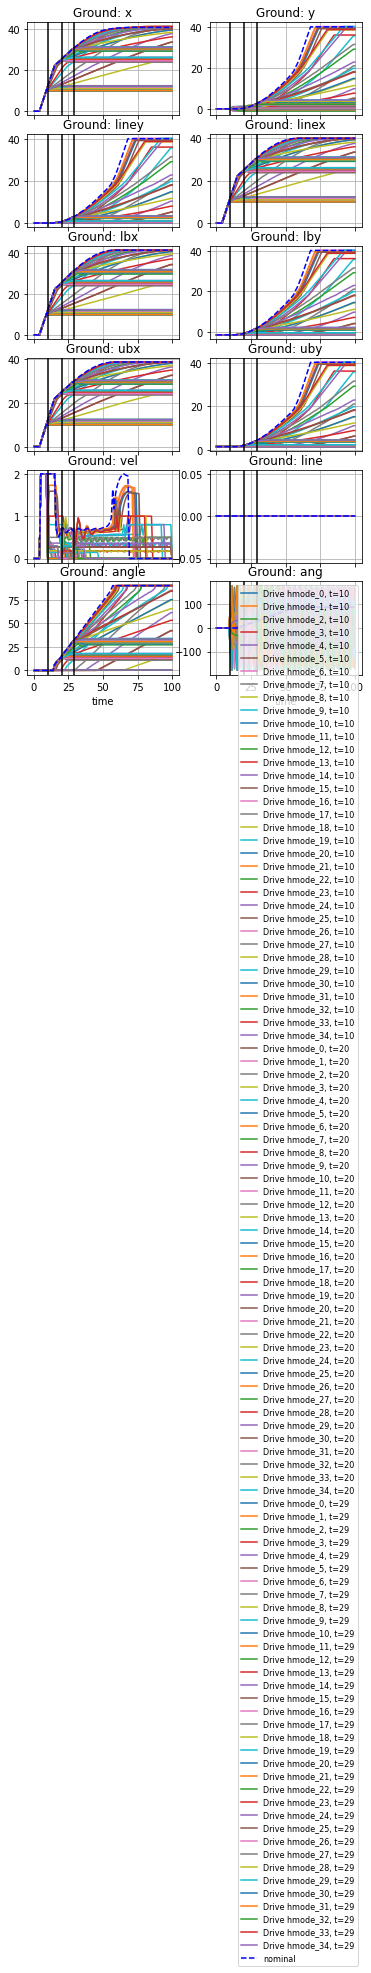

In [39]:
an.plot.mdlhists(rover_prob._sims['drive_faults']['mdlhists'], fxnflowvals="Ground", time_slice=app_drive.times)

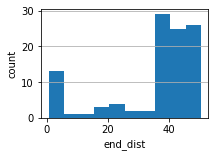

In [40]:
ecs = {k: v['endclass'] for k, v in rover_prob._sims['drive_faults']['results'].items()}
fig = an.plot.metric_dist(ecs, 'end_dist')

starting solution:

In [41]:
rover_prob.end_dist([0,0,0])

4179.790437219471

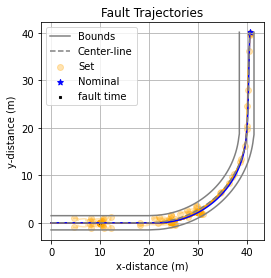

In [42]:
fig = plot_trajectories(rover_prob._sims['drive_faults']['mdlhists'], app= app_drive)

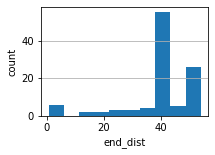

In [43]:
ecs = {k: v['endclass'] for k, v in rover_prob._sims['drive_faults']['results'].items()}
fig = an.plot.metric_dist(ecs, 'end_dist')

As shown, while the optimized correction factors don't mitigate all scenarios, they do increase the number of scenarios that are mitigated.